# Iphone Resell-value Analysis 
## Importing all dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

## Importing scraped data from ebay-terapeak

In [2]:
raw_data = pd.read_csv('MyScrape.csv')

## Setting up the derived columns and doing minor data preparation

In [3]:
raw_data['Model'] = raw_data['web-scraper-start-url'].str.extract(r'aspect=Modell%3A%3A%3A([^&]+)')
raw_data['Storage'] = raw_data['web-scraper-start-url'].str.extract(r'aspect=Speicherkapazit%C3%A4t%3A%3A%3A([^&]+)')
raw_data['Model'] = raw_data['Model'].str.replace('+', ' ')
raw_data['Storage'] = raw_data['Storage'].str.replace('+', ' ')
raw_data['Condition'] = 'gebraucht'

conditions = {
    'neu': 'neu',
    'neu sonstige': 'neu sonstige',
    'zertifiziert refurbished': 'zertifiziert refurbished',
    'hervorragend refurbished': 'hervorragend refurbished',
    'sehr gut refurbished': 'sehr gut refurbished',
    'gut refurbished': 'gut refurbished',
    'gebraucht': 'gebraucht',
    'defekt': 'defekt'
}
for condition, keyword in conditions.items():
    raw_data.loc[raw_data['Listing'].str.contains(keyword, case=False), 'Condition'] = condition

raw_data.drop(columns=['web-scraper-order', 'web-scraper-start-url', 'Listing'], inplace=True)

common_versions = {
    'Apple iPhone 11 Pro Max': '20.09.2019',
    'Apple iPhone 11 Pro': '20.09.2019',
    'Apple iPhone XS': '26.10.2018',
    'Apple iPhone XR': '26.10.2018',
    'Apple iPhone 11': '20.09.2019',
    'Apple iPhone X': '03.11.2017',
    'Apple iPhone 12': '23.10.2020',
    'Apple iPhone 12 Pro': '23.10.2020',
    'Apple iPhone 12 Pro Max': '23.10.2020',
    'Apple iPhone 12 mini': '23.10.2020',
    'Apple iPhone 13 mini': '24.09.2021',
    'Apple iPhone 13 Pro': '24.09.2021',
    'Apple iPhone 13 Pro Max': '24.09.2021',
    'Apple iPhone 13': '24.09.2021',
    'Apple iPhone 14 Pro': '16.09.2022',
    'Apple iPhone 14 Pro Max': '16.09.2022',
    'Apple iPhone 14': '16.09.2022'
}
raw_data['Release_date'] = raw_data['Model'].map(common_versions)

release_prices = {
    'Apple iPhone 11 Pro Max 64 GB': 1249,
    'Apple iPhone 11 Pro Max 256 GB': 1419,
    'Apple iPhone 11 Pro Max 512 GB': 1649,

    'Apple iPhone 11 Pro 64 GB': 1149,
    'Apple iPhone 11 Pro 256 GB': 1319,
    'Apple iPhone 11 Pro 512 GB': 1549,

    'Apple iPhone XS 64 GB': 999,
    'Apple iPhone XS 256 GB': 1149,
    'Apple iPhone XS 512 GB': 1349,

    'Apple iPhone XR 64 GB': 749,
    'Apple iPhone XR 128 GB': 799,
    'Apple iPhone XR 256 GB': 899,

    'Apple iPhone 11 64 GB': 699,
    'Apple iPhone 11 128 GB': 749,
    'Apple iPhone 11 256 GB': 849,

    'Apple iPhone X 64 GB': 999,
    'Apple iPhone X 256 GB': 1149,

    'Apple iPhone 12 64 GB': 829,
    'Apple iPhone 12 128 GB': 879,
    'Apple iPhone 12 256 GB': 979,

    'Apple iPhone 12 Pro 128 GB': 999,
    'Apple iPhone 12 Pro 256 GB': 1099,
    'Apple iPhone 12 Pro 512 GB': 1299,

    'Apple iPhone 12 Pro Max 128 GB': 1099,
    'Apple iPhone 12 Pro Max 256 GB': 1199,
    'Apple iPhone 12 Pro Max 512 GB': 1399,

    'Apple iPhone 12 mini 64 GB': 699,
    'Apple iPhone 12 mini 128 GB': 749,
    'Apple iPhone 12 mini 256 GB': 849,

    'Apple iPhone 13 mini 128 GB': 749,
    'Apple iPhone 13 mini 256 GB': 869,
    'Apple iPhone 13 mini 512 GB': 1099,

    'Apple iPhone 13 128 GB': 849,
    'Apple iPhone 13 256 GB': 969,
    'Apple iPhone 13 512 GB': 1199,

    'Apple iPhone 13 Pro 128 GB': 999,
    'Apple iPhone 13 Pro 256 GB': 1099,
    'Apple iPhone 13 Pro 512 GB': 1299,
    'Apple iPhone 13 Pro 1 TB': 1499,

    'Apple iPhone 13 Pro Max 128 GB': 1099,
    'Apple iPhone 13 Pro Max 256 GB': 1199,
    'Apple iPhone 13 Pro Max 512 GB': 1399,
    'Apple iPhone 13 Pro Max 1 TB': 1599,

    'Apple iPhone 14 128 GB': 849,
    'Apple iPhone 14 256 GB': 969,
    'Apple iPhone 14 512 GB': 1199,

    'Apple iPhone 14 Pro 128 GB': 999,
    'Apple iPhone 14 Pro 256 GB': 1099,
    'Apple iPhone 14 Pro 512 GB': 1299,
    'Apple iPhone 14 Pro 1 TB': 1499,

    'Apple iPhone 14 Pro Max 128 GB': 1099,
    'Apple iPhone 14 Pro Max 256 GB': 1199,
    'Apple iPhone 14 Pro Max 512 GB': 1399,
    'Apple iPhone 14 Pro Max 1 TB': 1599
}

raw_data['Combined'] = raw_data['Model'] + " " + raw_data['Storage']
raw_data['release_price'] = raw_data['Combined'].map(release_prices)
raw_data = raw_data.drop(columns=['Combined'])

raw_data['Date'] = pd.to_datetime(raw_data['Date'], format='%m/%d/%Y')
raw_data['Release_date'] = pd.to_datetime(raw_data['Release_date'], format='%d.%m.%Y')
raw_data['Time_used_days'] = (raw_data['Date'] - raw_data['Release_date']).dt.days

raw_data['Bids'].replace('–', 0, inplace=True)

raw_data['Storage'].replace('1 TB', '1024 GB', inplace=True)
raw_data['Storage'] = raw_data['Storage'].str.replace(' GB', '', regex=False).astype('int64')

raw_data.drop(['Shipping'], inplace=True, axis=1)

raw_data['Bids'] = raw_data['Bids'].astype('int64')

raw_data['Time_used_days'] = raw_data['Time_used_days'].apply(lambda x: max(x, 0))

raw_data = raw_data.assign(Total_sold=raw_data['Total sold'].apply(lambda x: [1]*x)).explode('Total_sold').reset_index(drop=True)
raw_data.drop(['Total sold'], axis=1, inplace=True)
raw_data.drop(['Total_sold'], axis=1, inplace=True)

raw_data['Price_incl_shipping'] = raw_data['Price'] + raw_data['Shipping_Cost']
raw_data.drop(['Shipping_Cost'], axis=1, inplace=True)

raw_data.drop(['Shipping_percent'], axis=1, inplace=True)

raw_data.drop(['Item_Revenue'], axis=1, inplace=True)

raw_data = raw_data.join(pd.get_dummies(raw_data.Sale_Format)).drop(['Sale_Format'], axis=1)

## Data exploration and minor analysis

In [4]:
data = raw_data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398471 entries, 0 to 398470
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Price                398471 non-null  float64       
 1   Bids                 398471 non-null  int64         
 2   Date                 398471 non-null  datetime64[ns]
 3   Model                398471 non-null  object        
 4   Storage              398471 non-null  int64         
 5   Condition            398471 non-null  object        
 6   Release_date         398471 non-null  datetime64[ns]
 7   release_price        398471 non-null  int64         
 8   Time_used_days       398471 non-null  int64         
 9   Price_incl_shipping  398471 non-null  float64       
 10  Auction              398471 non-null  bool          
 11  Fixed price          398471 non-null  bool          
dtypes: bool(2), datetime64[ns](2), float64(2), int64(4), object(2)
memory us

In [6]:
from sklearn.model_selection import train_test_split
X = data.drop(['Price'], axis=1)
y = data['Price']

In [7]:
X_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

array([[<Axes: title={'center': 'Bids'}>,
        <Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Storage'}>],
       [<Axes: title={'center': 'Release_date'}>,
        <Axes: title={'center': 'release_price'}>,
        <Axes: title={'center': 'Time_used_days'}>],
       [<Axes: title={'center': 'Price_incl_shipping'}>,
        <Axes: title={'center': 'Price'}>, <Axes: >]], dtype=object)

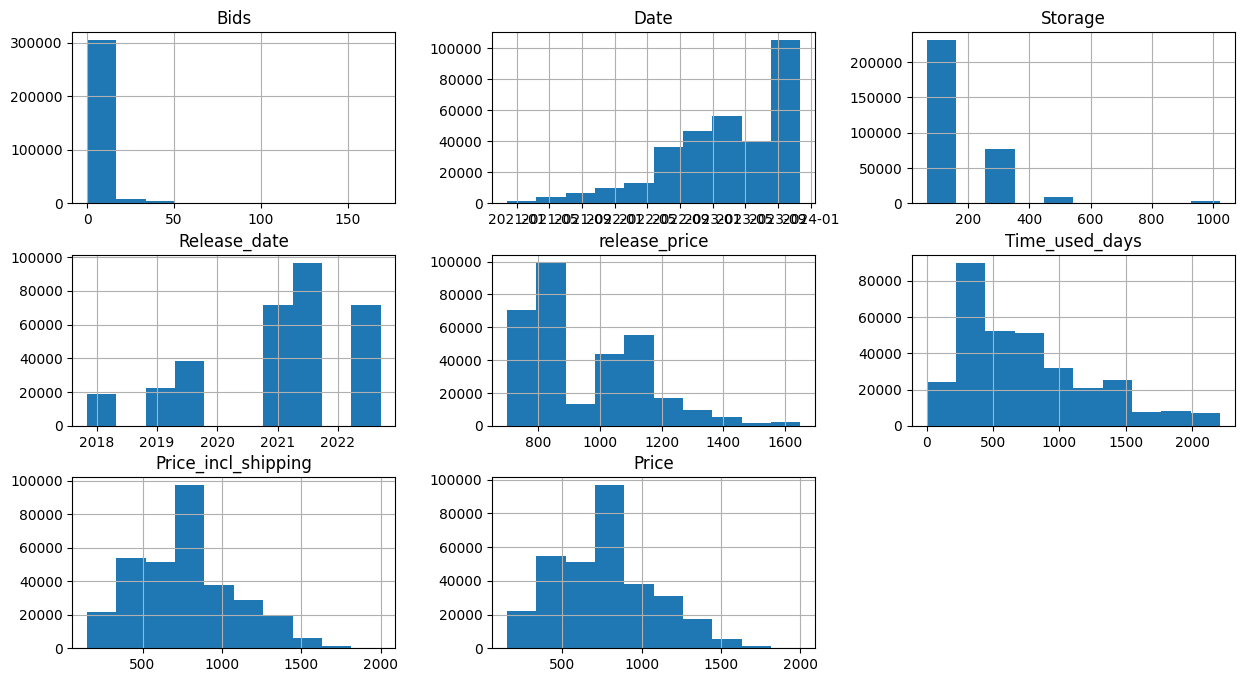

In [8]:
train_data= X_train.join(y_train)
train_data.hist(figsize=(15, 8))

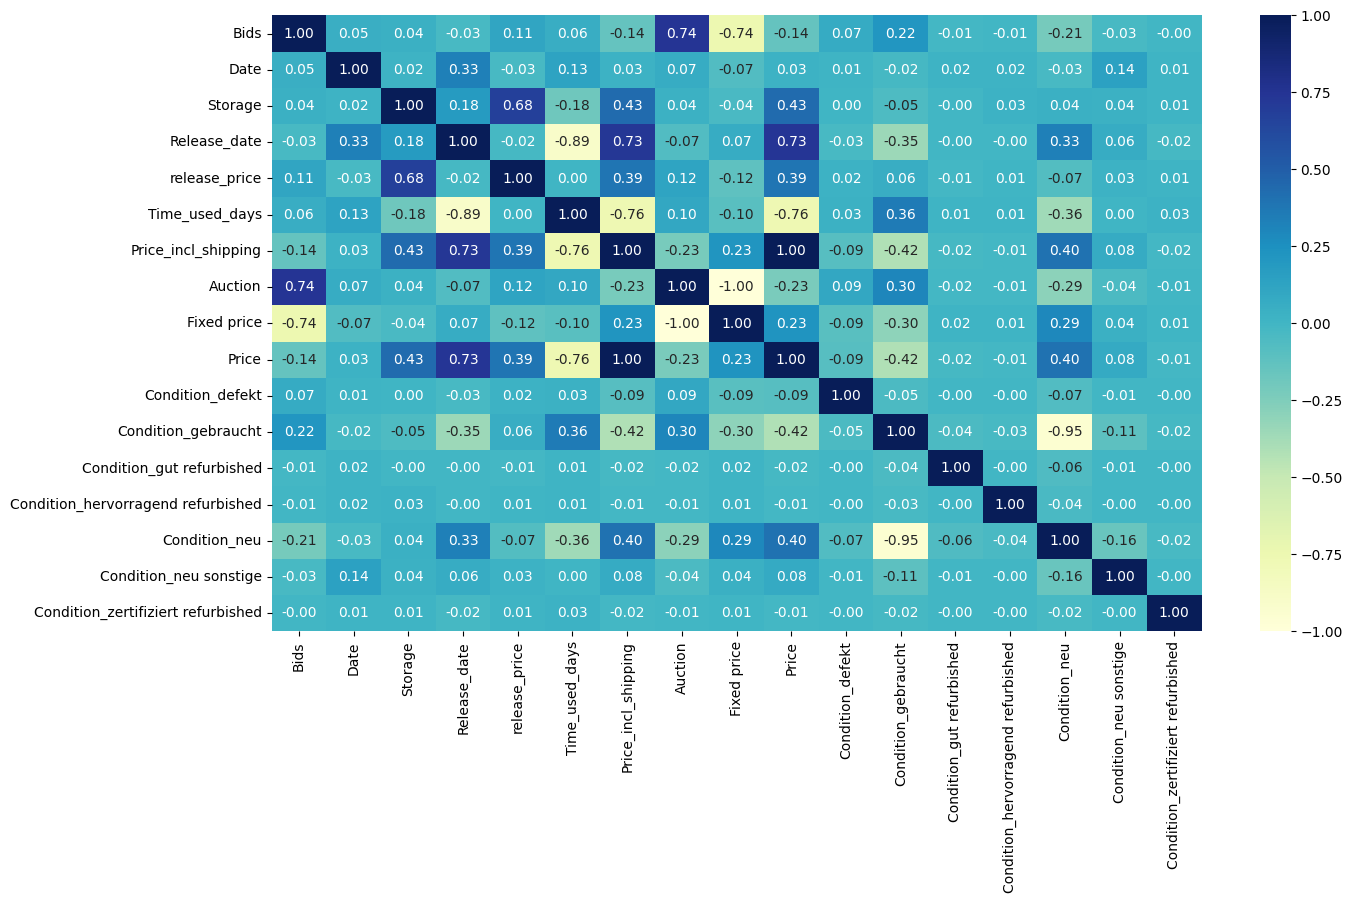

In [11]:
graph_data = train_data.drop(['Model'], axis=1)
categorical_columns = graph_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if col in graph_data.columns:
        graph_data = pd.concat([graph_data, pd.get_dummies(graph_data[col], prefix=col)], axis=1)
        graph_data.drop(col, axis=1, inplace=True)
corr_matrix = graph_data.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.show()

### a few interesting things to note before we continue here. the correlations look broadly as we would expect them to look. for example the release date of the phone is highly correlated to its sale price (older phones are worth less money). interestingly, the more bids an item received the worse its sale price ended up being (possibly because the listings with high amounts of bids already started out at a really low asking price). phones which are sold at a fixed price offer consistently sell for more than auction style listings. going forward we will assume that we are selling out phone at a fixed price and will only be looking at listings which are sold in this manner.